<!-- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb#scrollTo=lvDVFkg-2DPm -->

## Buscando um exemplo de CNN de previsão de valores 

Predicao de imagens:
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb#scrollTo=lvDVFkg-2DPm


Tuning hyperparameters
https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/



# CNN model

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers

import keras_tuner as kt 

# Lendo Dfs

In [2]:
# 60%
PATH_TREINO = '../Data/3_Gold/Treino_all_stocks.csv'
DF_TREINO = pd.read_csv(PATH_TREINO, sep=",")
train_dataset = DF_TREINO
train_dataset = train_dataset.drop(['oil_5','usd_5','abev_5','jbs_5','petr_5','vale_5',], axis=1)
train_labels = train_dataset.pop('ibova_5')

# 20%
PATH_VALIDACAO = '../Data/3_Gold/Validacao_all_stocks.csv'
DF_VALIDACAO = pd.read_csv(PATH_VALIDACAO, sep=",")
valid_dataset = DF_VALIDACAO
valid_dataset = valid_dataset.drop(['ibova_5','oil_5','usd_5','abev_5','jbs_5','petr_5','vale_5',],axis=1)
# valid_labels = valid_dataset.pop('ibova_5') 

# 20%
PATH_TESTE = '../Data/3_Gold/Teste_all_stocks.csv'
DF_TESTE = pd.read_csv(PATH_TESTE, sep=",")
test_dataset = DF_TESTE
test_dataset = test_dataset.drop(['oil_5','usd_5','abev_5','jbs_5','petr_5','vale_5',],axis=1)
test_labels = test_dataset.pop('ibova_5')


# Inspecionando os dados

In [ ]:
# sns.pairplot(train_dataset[['index','ibova_0','ibova_1','ibova_2','ibova_3','ibova_4','oil_0','oil_1','oil_2','oil_3','oil_4','usd_0','usd_1','usd_2','usd_3','usd_4']], diag_kind="kde")
# sns.pairplot(train_dataset[['index','ibova_0','oil_0','usd_0']], diag_kind="kde")
# sns.pairplot(train_dataset[['ibova_1','oil_1','usd_1']], diag_kind="kde")

train_stats = train_dataset.describe()
# train_stats

# Definindo o modelo

In [ ]:
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [58]:
def cnnpred_2d(seq_len=60, n_features=82, n_filters=(8,8,8), droprate=0.1):
    "2D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(seq_l,en, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

def model_builder(hp):
  hp_unit_1 = hp.Int('units', min_value=16, max_value=64, step=1)
  hp_unit_2 = hp.Int('units', min_value=4, max_value=64, step=1)
  hp_unit_3 = hp.Int('units', min_value=4, max_value=64, step=1)
  hp_unit_4 = hp.Int('units', min_value=4, max_value=64, step=1)

  model = keras.Sequential([
    layers.Conv2D(units=hp_unit_1, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(units=hp_unit_2, activation='relu'),
    layers.Dense(units=hp_unit_3, activation='relu'),
    layers.Dense(units=hp_unit_4, activation='relu'),
    layers.Dense(units=1, activation='linear')
  ])

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mae', 'mse'])

  
  return model


# rmse pra avaliação, nao para loss


In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 44)                1628      
_________________________________________________________________
dense_21 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_22 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_23 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 45        
Total params: 7,613
Trainable params: 7,613
Non-trainable params: 0
_________________________________________________________________


# Instanciando Tuner

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb#scrollTo=McO82AXOuxXh

### extra hipertuner
<!-- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/ -->

In [60]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mse',
                     max_epochs=10,
                     factor=3,
                     directory='logs',
                     project_name='hyper_parameters')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [62]:
# early_stop = keras.callbacks.EarlyStopping(
#   monitor='val_mse', patience=50, mode='min' ,restore_best_weights=True)
	
EPOCHS = 500

tuner.search(train_dataset, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=20)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 44 and the optimal learning rate for the optimizer
is 0.01.



# Selecionando a melhor epoca do modelo

In [42]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=1)

# Select the best epoch
val_mse_per_epoch = history.history['val_mse']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))


Epoch 1/500
36/36 [==============================] - 1s 14ms/step - loss: 91.7225 - mae: 3.8343 - mse: 91.7225 - val_loss: 0.2838 - val_mae: 0.4372 - val_mse: 0.2838
Epoch 2/500
36/36 [==============================] - 0s 6ms/step - loss: 0.3150 - mae: 0.4421 - mse: 0.3150 - val_loss: 0.7613 - val_mae: 0.7951 - val_mse: 0.7613
Epoch 3/500
36/36 [==============================] - 0s 5ms/step - loss: 0.4350 - mae: 0.4864 - mse: 0.4350 - val_loss: 0.5265 - val_mae: 0.6556 - val_mse: 0.5265
Epoch 4/500
36/36 [==============================] - 0s 5ms/step - loss: 0.7430 - mae: 0.5879 - mse: 0.7430 - val_loss: 3.3850 - val_mae: 1.8059 - val_mse: 3.3850
Epoch 5/500
36/36 [==============================] - 0s 5ms/step - loss: 0.2342 - mae: 0.3728 - mse: 0.2342 - val_loss: 0.0974 - val_mae: 0.2503 - val_mse: 0.0974
Epoch 6/500
36/36 [==============================] - 0s 5ms/step - loss: 0.0987 - mae: 0.2412 - mse: 0.0987 - val_loss: 0.5454 - val_mae: 0.6766 - val_mse: 0.5454
Epoch 7/500
36/36 [

# Treinando modelo

In [37]:
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(train_dataset, train_labels, epochs=best_epoch, validation_split=0.2, verbose=1)


Epoch 1/13
36/36 [==============================] - 1s 16ms/step - loss: 225.4082 - mae: 5.3892 - mse: 225.4082 - val_loss: 0.4839 - val_mae: 0.5701 - val_mse: 0.4839
Epoch 2/13
36/36 [==============================] - 0s 6ms/step - loss: 0.2400 - mae: 0.3862 - mse: 0.2400 - val_loss: 0.6685 - val_mae: 0.6812 - val_mse: 0.6685
Epoch 3/13
36/36 [==============================] - 0s 4ms/step - loss: 0.2270 - mae: 0.3766 - mse: 0.2270 - val_loss: 0.3009 - val_mae: 0.4349 - val_mse: 0.3009
Epoch 4/13
36/36 [==============================] - 0s 4ms/step - loss: 0.2125 - mae: 0.3622 - mse: 0.2125 - val_loss: 0.2940 - val_mae: 0.4303 - val_mse: 0.2940
Epoch 5/13
36/36 [==============================] - 0s 4ms/step - loss: 0.2295 - mae: 0.3749 - mse: 0.2295 - val_loss: 0.2954 - val_mae: 0.4317 - val_mse: 0.2954
Epoch 6/13
36/36 [==============================] - 0s 5ms/step - loss: 0.2297 - mae: 0.3795 - mse: 0.2297 - val_loss: 0.3085 - val_mae: 0.4396 - val_mse: 0.3085
Epoch 7/13
36/36 [=====

In [38]:
eval_result = hypermodel.evaluate(test_dataset, test_labels)
print("[test loss, test accuracy]:", eval_result)

15/15 [==============================] - 0s 2ms/step - loss: 0.4652 - mae: 0.4281 - mse: 0.4652
[test loss, test accuracy]: [0.4652468264102936, 0.4281114339828491, 0.4652468264102936]


# Avaliando o modelo

In [ ]:
# print(f'train_dataset: {train_dataset.columns()} \n')
# print(f'valid_dataset: {valid_dataset.columns()} \n')
# print(f'test_dataset: {test_dataset.columns()} \n')

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,166.980042,5.030573,166.980042,26.591406,5.12968,26.591406,0


In [39]:
print(f'Min MSE: {hist.mse.min()}')
print(f'Min Val_MSE: {hist.val_mse.min()}')

Min MSE: 166.98004150390625
Min Val_MSE: 26.591405868530273


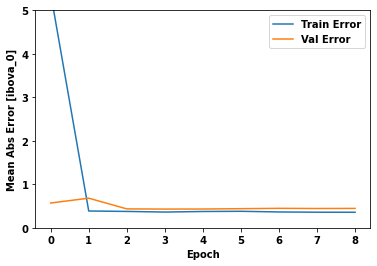

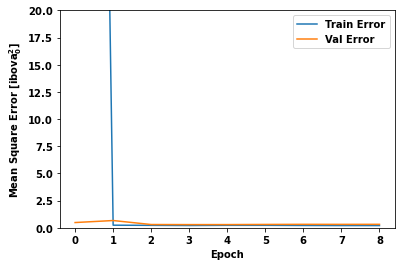

In [40]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ibova_0]')
  plt.plot(hist['epoch'], hist['mae'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ibova_0^2$]')
  plt.plot(hist['epoch'], hist['mse'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
model = build_model()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse', patience=25, mode='min' ,restore_best_weights=True)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop, tensorboard_callback])

# Mudar os dados de validação

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print(f"Testing set Mean Abs Error: {mse:5.2f} ibova_0")

# Realizando as previsões

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

# Avaliando as previsões:

In [ ]:
def show_test_labels():
	# Imprimindo valores reais
	plt.plot(test_labels, color ='r', label='ibova_REAL')
	plt.xlabel("Dates")
	plt.ylabel("Variation ROC")
	plt.title("ibova_REAL")
	plt.legend()

def show_model_predictions():
	# Imprimindo previsoes
	plt.plot(test_predictions, color ='g', label='predictions_MODEL')
	plt.xlabel("Dates")
	plt.ylabel("Variation ROC")
	plt.title("predictions_MODEL")
	plt.legend()

def show_compare_graph():
	# Predictt X Real values
	plt.plot(test_labels, color ='r', label='ibova_REAL')
	plt.plot(test_predictions, color ='g', label='predictions_MODEL')
	plt.xlabel("Dates")
	plt.ylabel("Variation ROC")
	plt.title("Predict X Real values")
	plt.legend()
	plt.show()

def show_true_predict_values():
	plt.figure(figsize=(24,4))
	plt.scatter(test_labels, test_predictions)
	plt.xlabel('True Values [ibova_0]')
	plt.ylabel('Predictions [ibova_0]')
	plt.axis('equal')
	plt.axis('square')
	plt.xlim([0,plt.xlim()[1]])
	plt.ylim([0,plt.ylim()[1]])
	_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
show_compare_graph()

In [ ]:
show_model_predictions()

In [ ]:
# Analisando Medias:

print(f'Massa de predição: {test_predictions.mean()}')
print(f'Massa inicial: {ibova_test.mean()}')
print(f'Diferenças das médias: {ibova_test.mean() - test_predictions.mean()}')

# Add o RM_MSE medio

In [ ]:
# test_dataset